# 

In [1]:
import numpy as np
import sys,os
sys.path.append(os.getcwd()[:-11]+'src/')
from models import *
from topological_methods import *
import matplotlib.pyplot as plt
clrs = plt.cm.tab20.colors

In [2]:
from torchvision import datasets, transforms

transform=transforms.Compose([transforms.ToTensor()])

data_train = datasets.MNIST('/Users/kosio/Data/MNIST/', train=True, transform=transform, download=True)
data_test = datasets.MNIST('/Users/kosio/Data/MNIST/', train=False, transform=transform,download=True)

trainloader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=True)


/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <632A2621-54FC-39C2-963C-47795485AE07> /Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#output before training
layer_sizes = [2000,1000,500,100]

model = FeedforwardNetwork(input_size=data_train.data.shape[1]*data_train.data.shape[2]
                           ,hidden_sizes=layer_sizes, out_layer_sz=10, init_type='none',
                          mean = 0, std=0.01)
model_pos = FeedforwardNetwork(input_size=data_train.data.shape[1]*data_train.data.shape[2]
                           ,hidden_sizes=[1000,500,250,100], out_layer_sz=10, init_type='normal',
                          mean = 0, std=0.01)
#                          mean = 0, std=1)
net_rank_ratio = 0.1
for layer in model_pos.layers[:-1]:
    if isinstance(layer, nn.Linear):
        R = torch.eye(layer.weight.shape[0])
        rand_inds = np.random.choice(np.arange(0,layer.weight.shape[0]),
                                     size=int(net_rank_ratio*layer.weight.shape[0]), replace=False)
        R[rand_inds,rand_inds] = -1
        layer.weight = torch.nn.Parameter(abs(layer.weight))
        #with torch.no_grad():
            #layer.weight[:int(len(layer.weight))] = -layer.weight[:int(len(layer.weight))]
            #layer.weight[:,:int(len(layer.weight.T))] = -layer.weight[:,:int(len(layer.weight.T))]
        layer.weight = torch.nn.Parameter(R@torch.abs(layer.weight))#torch.nn.Parameter(layer.weight+0.0001)#

out = model(data_test.data.reshape(len(data_test.data),-1).float())
out_code = [torch.sum(out[i]>0,axis=1) for i in range(len(out))]

out_pos = model_pos(data_test.data.reshape(len(data_test.data),-1).float())
out_code_pos = [torch.sum(out_pos[i]>0,axis=1) for i in range(len(out_pos))]


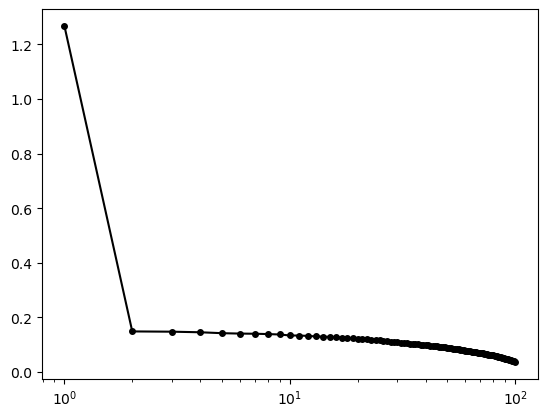

In [4]:
eigval = np.linalg.svd(model_pos.layers[6].weight.detach().numpy())[1]
plt.plot(np.arange(1,len(eigval)+1),eigval,'k-o',markersize=4)
plt.xscale('log')

In [5]:
rand_samples = 255*torch.randn(data_test.data.reshape(len(data_test.data),-1).shape)

out_pre_rand = model(rand_samples)
out_code_pre_rand = [torch.sum(out_pre_rand[i]>0,axis=1) for i in range(len(out_pre_rand))]


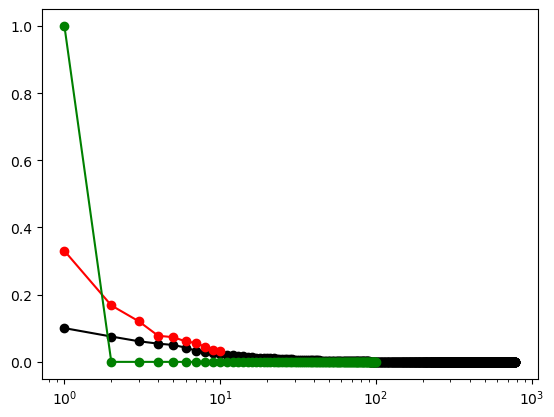

In [6]:
#show the PCA spectrum of the MNIST data
from sklearn.decomposition import PCA
reduced_MNIST = PCA().fit(data_test.data.reshape(len(data_test.data),-1).float())
reduced_output = PCA().fit(out[-1].detach().numpy())
reduced_output_pos = PCA().fit(out_pos[-2].detach().numpy())

plt.plot(np.arange(1,785),reduced_MNIST.explained_variance_ratio_,'k-o')
plt.plot(np.arange(1,len(reduced_output.explained_variance_ratio_)+1),reduced_output.explained_variance_ratio_,'r-o')
plt.plot(np.arange(1,len(reduced_output_pos.explained_variance_ratio_)+1),reduced_output_pos.explained_variance_ratio_,'g-o')
plt.xscale('log')

In [7]:
#Train
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer_pos = optim.Adam(model_pos.parameters(), lr=0.001)

# Define the training function
def train_model(model, trainloader, criterion, optimizer, num_epochs=20):
    model.train()  # Set the model to training mode
    for epoch in tqdm(range((num_epochs))):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs.reshape(len(inputs),-1))[-1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if epoch % 50 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

# Train the model
train_model(model, trainloader, criterion, optimizer)
#train_model(model_pos, trainloader, criterion, optimizer_pos)


  5%|██▎                                           | 1/20 [00:20<06:22, 20.13s/it]

[1,   938] loss: 0.440


100%|█████████████████████████████████████████████| 20/20 [06:51<00:00, 20.56s/it]


In [8]:
#output after training
out_post = model(data_test.data.reshape(len(data_test.data),-1).float())
out_code_post = [torch.sum(out_post[i]>0,axis=1) for i in range(len(out_post))]

out_post_pos = model_pos(data_test.data.reshape(len(data_test.data),-1).float())
out_code_post_pos = [torch.sum(out_post_pos[i]>0,axis=1) for i in range(len(out_post_pos))]

In [9]:
#run model through random images to see if low ranks are placed near data samples or if in general the space is lower rank
out_rand = model(rand_samples)
out_code_rand = [torch.sum(out_rand[i]>0,axis=1) for i in range(len(out_rand))]

out_rand_pos = model_pos(data_test.data.reshape(len(data_test.data),-1).float())
out_code_rand_pos = [torch.sum(out_post_pos[i]>0,axis=1) for i in range(len(out_post_pos))]

In [10]:
print((sum(torch.argmax(out_post[-1],1)==data_test.targets)/len(data_test.targets)).item())
print((sum(torch.argmax(out_post_pos[-1],1)==data_test.targets)/len(data_test.targets)).item())

0.9825000166893005
0.10320000350475311


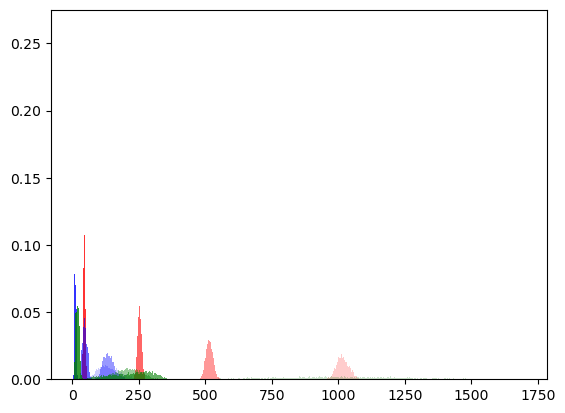

In [11]:
[plt.hist(out_code[i],np.linspace(torch.min(out_code[i]),torch.max(out_code[i]),
                                  torch.max(out_code[i])-torch.min(out_code[i])),
                                  color='red',alpha = i*0.2+0.2,density=True) for i in range(len(out_code)-1)]

[plt.hist(out_code_post[i],np.linspace(torch.min(out_code_post[i]),torch.max(out_code_post[i]),
                                  torch.max(out_code_post[i])-torch.min(out_code_post[i])),
                                  color='blue',alpha = i*0.2+0.2,density=True) for i in range(len(out_code_post)-1)]

_ = [plt.hist(out_code_rand[i],np.linspace(torch.min(out_code_rand[i]),torch.max(out_code_rand[i]),
                                  torch.max(out_code_rand[i])-torch.min(out_code_rand[i])),
                                  color='green',alpha = i*0.2+0.2,density=True) for i in range(len(out_code_rand)-1)]


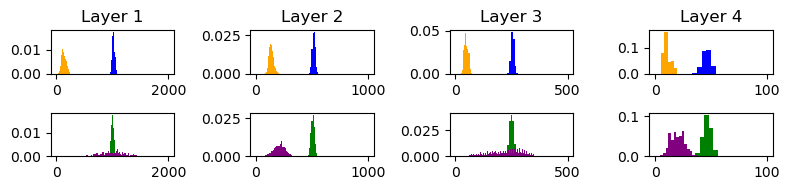

In [12]:
fig, ax = plt.subplots(2,len(out_code)-1,figsize=(8,2))

for i in range(len(out_code)-1):
    ax[0,i].hist(out_code[i],np.linspace(0,layer_sizes[i],
                                  torch.max(out_code[i])-torch.min(out_code[i])),
                                  color='blue',density=True)
    ax[0,i].hist(out_code_post[i],np.linspace(0,layer_sizes[i],
                                  torch.max(out_code_post[i])-torch.min(out_code_post[i])),
                                  color='orange',density=True)

    ax[0,i].set_title("Layer " + str(i+1))

    ax[1,i].hist(out_code_pre_rand[i],np.linspace(0,layer_sizes[i],
                                  torch.max(out_code_pre_rand[i])-torch.min(out_code_pre_rand[i])),
                                  color='green',density=True)
    ax[1,i].hist(out_code_rand[i],np.linspace(0,layer_sizes[i],
                                  torch.max(out_code_rand[i])-torch.min(out_code_rand[i])),
                                  color='purple',density=True)
fig.tight_layout()
fig.savefig("../MNIST_code_hist.png",dpi=500)

## Regression problem

In [13]:
from test_functions import OptFunctions
from torch.utils.data import Dataset, TensorDataset

functions = OptFunctions(10000,2)

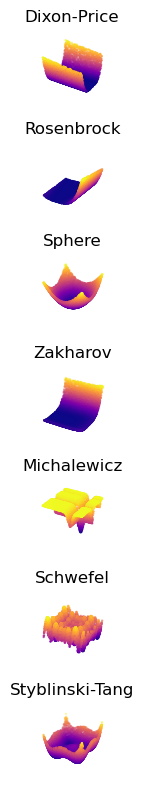

In [14]:
all_functions = [(method_name,method) for method_name, method in OptFunctions.__dict__.items() if callable(method) 
                    and not method_name.startswith("__")]
function_names = ['Dixon-Price','Rosenbrock','Sphere','Zakharov','Michalewicz','Schwefel','Styblinski-Tang']

fig, axs = plt.subplots(len(all_functions),1,figsize=(16,8),subplot_kw={'projection': '3d'})

for i in range(len(all_functions)):
    x, f_x = all_functions[i][1](functions)

    axs[i].scatter(x[0], x[1], f_x, c=f_x, cmap='plasma',s=0.5) 
    
    axs[i].axis('off')
    axs[i].set_title(function_names[i])
fig.tight_layout()
fig.savefig("../opt_functions.png",dpi=500,transparent=True)

In [25]:
discrete = False
f_dim = 20
n_samples = 10000
opt_functions = OptFunctions(n_samples,f_dim,discretize=discrete,z_score=True)
callable_methods = [method for method_name, method in OptFunctions.__dict__.items() if callable(method) 
                    and not method_name.startswith("__")]
criterion_reg = nn.MSELoss()

pretrained_codewords = []
postrained_codewords = []

#fig, axs = plt.subplots(len(all_functions),1,figsize=(16,8),subplot_kw={'projection': '3d'})

for func in callable_methods:
    x_train, f_train = func(opt_functions)
    x_test, f_test = func(opt_functions)
    
    x_train, x_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32)
    f_train, f_test = torch.tensor(f_train, dtype=torch.float32), torch.tensor(f_test, dtype=torch.float32)

    reg_data_train = TensorDataset(x_train.T, f_train)
    reg_data_test = TensorDataset(x_test.T, f_test)
    trainloader_reg = torch.utils.data.DataLoader(reg_data_train, batch_size=64, shuffle=True)
    testloader_reg = torch.utils.data.DataLoader(reg_data_test, batch_size=64, shuffle=True)

    model_reg = FeedforwardNetwork(input_size=f_dim,hidden_sizes=[8*f_dim,4*f_dim,2*f_dim], 
                               out_layer_sz=1, init_type='none',activation=nn.ReLU())
    
    out_reg = model_reg(x_test.T)
    out_reg_code = [torch.sum(out_reg[i]>0,axis=1) for i in range(len(out_reg))]
    pretrained_codewords.append(out_reg_code)

    if discrete:
        optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)
    else:
        optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.0001)
        
    num_epochs = 1000
    loss_hist = []
    for epoch in range(num_epochs):
        for inputs, targets in trainloader_reg:
            # Forward pass
            outputs = model_reg(inputs)[-1]
            loss = criterion_reg(outputs, targets.unsqueeze(1))
    
            # Backward pass and optimization
            optimizer_reg.zero_grad()
            loss.backward()
            optimizer_reg.step()
            loss_hist.append(loss.item())
    
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    model_reg.eval()
    with torch.no_grad():
        out_reg_trained = model_reg(x_test.T)
    out_reg_code_trained = [torch.sum(out_reg_trained[i]>0,axis=1) for i in range(len(out_reg_trained))]
    postrained_codewords.append(out_reg_code_trained)

#    axs[i].scatter(x_test.detach()[0], x_test.detach()[1], out_reg_trained.detach(), c=out_reg_trained.detach(), cmap='plasma',s=0.5) 
    
#    axs[i].axis('off')

#fig.tight_layout()

#if discrete:
#    fig.savefig("../ST_discrete_3d.png", dpi=500,transparent=True)
#else:
#    fig.savefig("../ST_continuous_3d.png", dpi=500,transparent=True)

Epoch [100/1000], Loss: 0.0586
Epoch [200/1000], Loss: 0.0208
Epoch [300/1000], Loss: 0.0178
Epoch [400/1000], Loss: 0.0031
Epoch [500/1000], Loss: 0.0050
Epoch [600/1000], Loss: 0.0014
Epoch [700/1000], Loss: 0.0018
Epoch [800/1000], Loss: 0.0010
Epoch [900/1000], Loss: 0.0017
Epoch [1000/1000], Loss: 0.0012
Epoch [100/1000], Loss: 0.1218
Epoch [200/1000], Loss: 0.0149
Epoch [300/1000], Loss: 0.0138
Epoch [400/1000], Loss: 0.0147
Epoch [500/1000], Loss: 0.0031
Epoch [600/1000], Loss: 0.0022
Epoch [700/1000], Loss: 0.0011
Epoch [800/1000], Loss: 0.0027
Epoch [900/1000], Loss: 0.0013
Epoch [1000/1000], Loss: 0.0007
Epoch [100/1000], Loss: 0.0375
Epoch [200/1000], Loss: 0.0049
Epoch [300/1000], Loss: 0.0043
Epoch [400/1000], Loss: 0.0016
Epoch [500/1000], Loss: 0.0029
Epoch [600/1000], Loss: 0.0014
Epoch [700/1000], Loss: 0.0008
Epoch [800/1000], Loss: 0.0014
Epoch [900/1000], Loss: 0.0009
Epoch [1000/1000], Loss: 0.0005
Epoch [100/1000], Loss: 0.0217
Epoch [200/1000], Loss: 0.0062
Epoch

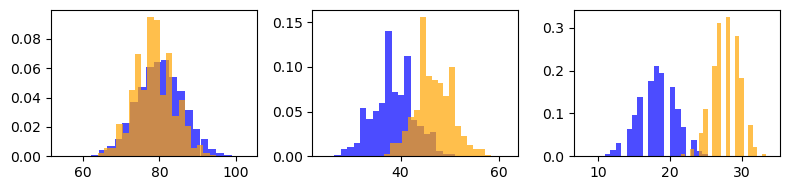

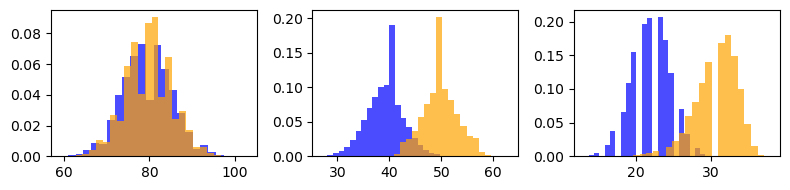

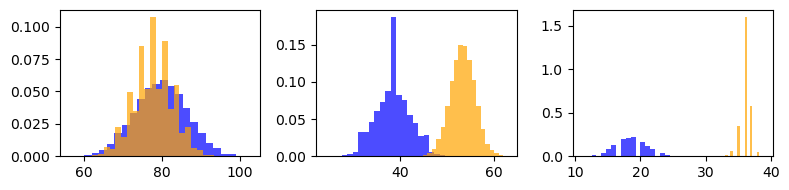

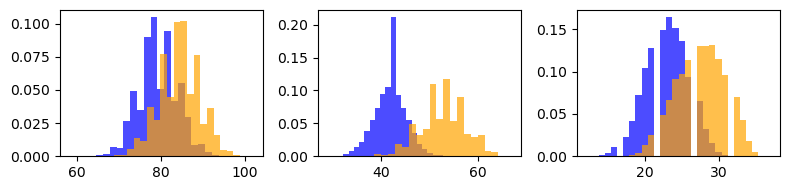

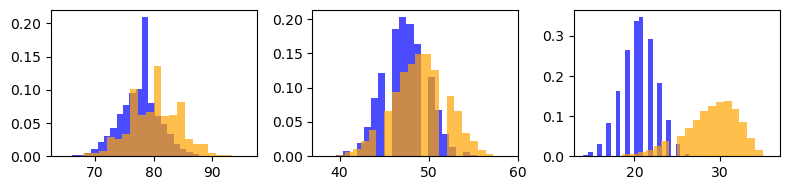

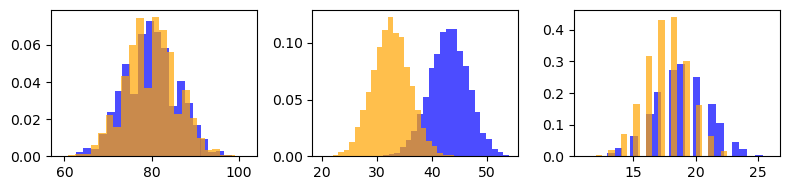

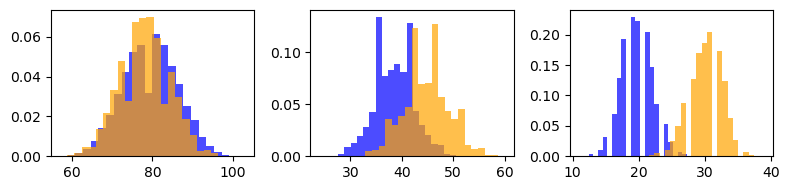

In [26]:
if discrete:
    color_hists = ['black','red']
else:
    color_hists = ['blue','orange']
for n,fnames in enumerate(function_names) :
    fig, ax = plt.subplots(1,len(out_reg_code)-1,figsize=(8,2))

    for i in range(len(out_reg_code)-1):
        ax[i].hist(pretrained_codewords[n][i],np.linspace(torch.min(pretrained_codewords[n][i]),
                                                          torch.max(pretrained_codewords[n][i]),25),
                                      color=color_hists[0],density=True,alpha=0.7)
        ax[i].hist(postrained_codewords[n][i],np.linspace(torch.min(postrained_codewords[n][i]),
                                                          torch.max(postrained_codewords[n][i]),25),
                                          color=color_hists[1],density=True,alpha=0.7)
    fig.tight_layout()
    
    if discrete:
        fig.savefig("../"+fnames+"_discrete_hist.png", dpi=500,transparent=True)
    else:
        fig.savefig("../"+fnames+"_continuous_hist.png", dpi=500,transparent=True)